In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Калибровка камеры по одному кадру.

ЗАДАНИЕ: по заданным парам точек $x_i$ на изображении и $X_i$ в пространстве
необходимо найти оценку матрицы перспективной камеры $\mathbf{M}$,
т.е. решить PnP задачу (см лекцию 1).

Алгоритм должен включать следующие этапы:
1. Инициализация матрицы камеры $\mathbf{M}$ методом DLT, БЕЗ Ransac.
2. Уточнение матрицы камеры $\mathbf{M}$ методом градиентной оптимизации 
ошибки репроекции вида:
$$\mathcal{L}(x_i, X_i) = \sum\| \mathbf{M}X_i - x_i \|^2$$
3. Факторизация матрицы $\mathbf{M}$ на внешние и внутренние параметры.

In [101]:
%%bash
if [ ! -d assets/ ]; then
    curl -sO 'https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/assets.zip'
    unzip -qo assets.zip
fi

In [102]:
image_path = 'assets/image.jpg'
corners_path = 'assets/corners.txt'
coords_path = 'assets/coords.txt'

(1280, 960, 3)

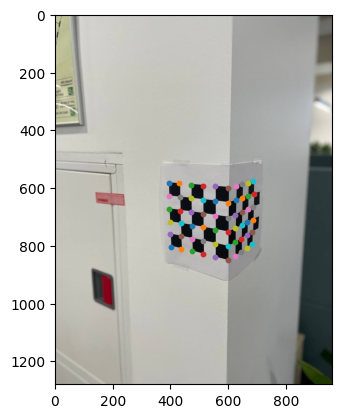

In [103]:
x3d = np.loadtxt(coords_path)
x2d = np.loadtxt(corners_path)

img = cv2.imread(image_path)
h, w, _ = img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
for x in x2d:
    plt.scatter(*x, s=10)
    
img.shape

Ожидаемый результат:<br/><img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/image1.png" style="display:inline-block"/>

In [104]:
def to_homo(x):
    return np.concatenate([x, np.ones(x.shape[0])[..., None]], axis=1)       

def to_cartesian(x):
    return (x / x[..., -1:])[..., :-1]

def geometric_distance(x, y):
    return np.sum((x-y)**2)

## Шаг 1. DLT инициализация матрицы камеры
Линейная оценка матрицы камеры может быть получена из решения линейного уравнения вида (см лекция 1):
$$\Large A \cdot \vec{m}^T = 0$$

In [105]:
def build_system(x3d, x2d):
    # input: x3d - world points
    #        x2d - pixel coords
    # ouptut: A - [2n, 12] matrix
    n = x3d.shape[0]
    A = np.zeros((2 * n) *  12).reshape((2 * n, 12))
    
    for i in range(n):
        X, Y, Z, _ = x3d[i]
        x, y, _ = x2d[i]
        
        A[2 * i]     = [X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x]
        A[2 * i + 1] = [0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y]
    
    return A

def solve_system(A):
    # input: A - matrix
    # output: solution for Am = 0
    U, S, Vt = np.linalg.svd(A)
    v = Vt[-1]
    
    return v

In [106]:
A = build_system(to_homo(x3d), to_homo(x2d))
M = solve_system(A).reshape(3,4)

`cross-check:0` (5 баллов)

In [107]:
coarse = geometric_distance(x2d, to_cartesian((M@to_homo(x3d).T).T))
assert coarse < 50

In [108]:
print(coarse)

45.268310871877325


### Шаг 2. Уточнение матрицы градиентным методом

Для уточнения матрицы $\mathbf{M}$ используем градиентный метод оптимизации: Levenberg-Marquardt algorithm.
Рекомендуется использовать его имплементацию из пакета scipy. 

** попробуйте разные виды остатков

In [109]:
from scipy.optimize import least_squares

def loss_func(v0, x3d, x2d):
    M0 = v0.reshape(3, 4)
    proj = (M0 @ to_homo(x3d).T).T
    proj = proj / proj[:, -1][:, np.newaxis]
    proj = proj[:, :2]
    residuals = proj - x2d
    #print(residuals)
    return residuals.flatten()

def refine(DLT_M, x3d, x2d):
    # input: DLT_M - coarse estimate
    # (optional) x2d, x3d
    # output: refined solution for M
    v0 = DLT_M.flatten()
    res = least_squares(loss_func, v0, args=(x3d, x2d), method='lm')
    refined_v = res.x
    return refined_v.reshape(3, 4)

In [110]:
M = refine(M, x3d, x2d)

`cross-check:1` (2 балла)

In [111]:
fine = geometric_distance(x2d, to_cartesian((M@to_homo(x3d).T).T))
assert fine < coarse

In [112]:
print(fine)

45.16456524725572


### Шаг 3. Факторизация матрицы камеры
На этом этапе необходимо получить внешиние и внутренние параметры камеры вида:
$$\mathbf{M} = \mathbf{K} \big[\mathbf{R} | \mathbf{t}\big]$$

$\mathbf{K}$ - верхнетреугольная матрица с положительными числами

$\mathbf{R}$ - ортогональная матрица с положительным детерминантом

$t$ - вектор из трех чисел

In [113]:
def factorize(M):
    # input: M
    # output: K, R, t
    pass


def factorize(M):
    A = M[:, :3]
    b = M[:, 3]
    
    K, R =  np.linalg.qr(np.flipud(A).T)
    R = np.flipud(R.T)
    K = np.flipud(K.T)
    
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Если детерминант R отрицательный, меняем знаки
    if np.linalg.det(R) < 0:
        R = -R
        K = -K
    
    # Вычисляем вектор трансляции
    t = np.linalg.inv(K) @ b
    
    return K / K[2][2], R, t


import numpy as np

def factorize(M):
    A = M[:, :3]
    b = M[:, 3]
    
    # Для получения RQ-разложения нужно перевернуть матрицу A по вертикали и горизонтали.
    A_flipped = np.flipud(np.fliplr(A))
    
    # Выполняем QR-разложение транспонированной перевёрнутой матрицы
    Q, R = np.linalg.qr(A_flipped.T)
    
    # Восстанавливаем матрицы, возвращая транспонирование и перевороты по горизонтали и вертикали:
    R = np.flipud(np.fliplr(R.T))
    Q = np.flipud(np.fliplr(Q.T))
    
    # Здесь R будет верхнетреугольной матрицей, которая соответствует нашей K,
    # а Q — ортогональной матрицей, которая соответствует R.
    K = R
    R = Q

    # Корректируем знаки диагональных элементов K, чтобы они были положительными.
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    
    # Если детерминант матрицы R отрицательный, меняем знаки (требуется для корректной ориентации)
    if np.linalg.det(R) < 0:
        R = -R
        K = -K
    
    # Вычисляем вектор трансляции: t = K⁻¹ * b
    t = np.linalg.inv(K) @ b
    
    # Нормируем K так, чтобы K[2,2] был равен 1
    return K / K[2, 2], R, t




In [114]:
K, R, t = factorize(M)
print(f"{K = }")
print(f"{R = }")
print(f"{t = }")

K = array([[1.00435772e+03, 4.58526117e+00, 4.77427848e+02],
       [0.00000000e+00, 1.00052088e+03, 6.65827523e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
R = array([[ 0.57504167, -0.8180294 , -0.01244891],
       [-0.17785882, -0.11014615, -0.97787221],
       [ 0.79855702,  0.56453142, -0.20883237]])
t = array([ 2.37654229,  3.62916893, 19.74263675])


`cross-check:2` (3 балла)

In [115]:
assert np.isclose(K[2,2], 1)
assert np.isclose(np.linalg.det(R), 1)
assert np.abs(K[0,2] - 960 / 2) < 30
assert np.abs(K[1,2] - 1280 / 2) < 30
assert (K[0, 0] > 1000) & (K[1, 1] > 1000)

In [116]:
def make_grid(M):
    x3d = [[0, i, k] for i in range(10) for k in range(-5, 10)] + [[i, 0, k] for i in range(10) for k in range(-5, 10)]
    x3d = np.array(x3d)    
    
    x2d = to_cartesian((M@to_homo(x3d).T).T)
    
    plt.subplots(figsize=(10, 10))
    plt.imshow(img)
    plt.scatter(x2d[..., 0], x2d[..., 1], s=20, color='green', marker='x')

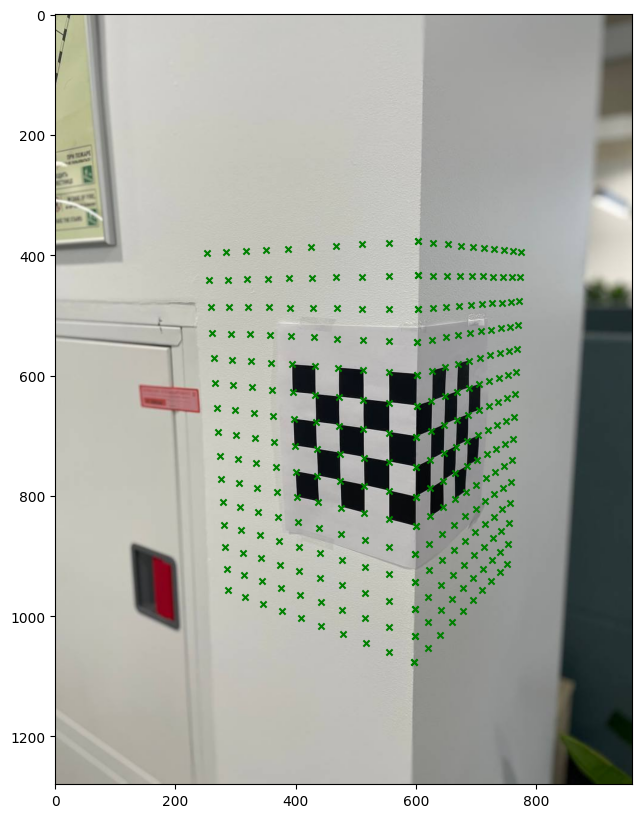

In [117]:
make_grid(M)

Ожидаемый результат:<br/><img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/image2.png" style="display:inline-block"/>